# **Seattle Micromobility: Collision Analysis**

## **Part 2**

This notebook continues the analysis of micromobility-related collisions in Seattle. 

The goal is to:
- Identify **spatiotemporal patterns** in micromobility-related collisions.
- Locate **collision hotspot** using clustering techniques.
- Examine the correlation between collisions and **infrastructure elements** (e.g., sidewalks, bike lanes).
- Explore how **geographic features** (slope) influence  collision risks.

## **Import Required Libraries**

In [72]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import contextily as ctx
from shapely.ops import nearest_points
import requests
from scipy.stats import gaussian_kde

In [3]:
%matplotlib inline

## **Load cleaned data**

In [4]:
collision_file = "/home/jovyan/seattle-micromobility/data/processed/seattle_collisions.geojson"
bike_facilities_file = "/home/jovyan/seattle-micromobility/data/processed/seattle_bike_facilities.geojson"
multi_use_trails_file = "/home/jovyan/seattle-micromobility/data/processed/seattle_multi_use_trails.geojson"
sidewalks_file = "/home/jovyan/seattle-micromobility/data/processed/seattle_sidewalks.geojson"

collisions_gdf = gpd.read_file(collision_file)
bike_facilities_gdf = gpd.read_file(bike_facilities_file)
multi_use_trails_gdf = gpd.read_file(multi_use_trails_file)
sidewalks_gdf = gpd.read_file(sidewalks_file)

print(f"Collisions: {len(collisions_gdf)}")
print(f"Bike Facilities: {len(bike_facilities_gdf)}")
print(f"Multi-use Trails: {len(multi_use_trails_gdf)}")
print(f"Sidewalks: {len(sidewalks_gdf)}")

Collisions: 36334
Bike Facilities: 3540
Multi-use Trails: 203
Sidewalks: 46081


## **Retrieve Road Network from OpenStreetMap**

Use the `osmx` library to extract Seattle's **road network** from OpenStreetMap (OSM).

In [6]:
place_name = "Seattle, Washington, USA"
G = ox.graph_from_place(place_name, network_type="all")
edges = ox.graph_to_gdfs(G, nodes=False)

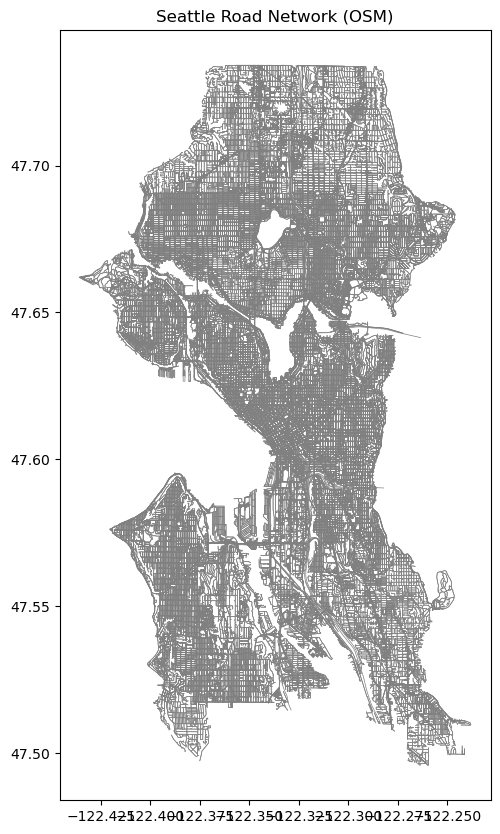

In [8]:
#Plot the road network

fig, ax = plt.subplots(figsize=(10,10))
edges.plot(ax=ax, color='gray', lw=0.5)
plt.title("Seattle Road Network (OSM)")
plt.show()

In [9]:
# Save edges to GeoJSON
edges_path = "/home/jovyan/seattle-micromobility/data/processed/seattle_road_edges.geojson"
edges.to_file(edges_path, driver="GeoJSON")

In [3]:
road_file = "/home/jovyan/seattle-micromobility/data/processed/seattle_road_edges.geojson"
road_gdf = gpd.read_file(road_file)

Skipping field highway: unsupported OGR type: 5
Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field bridge: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field tunnel: unsupported OGR type: 5
Skipping field access: unsupported OGR type: 5
Skipping field service: unsupported OGR type: 5
Skipping field width: unsupported OGR type: 5


In [4]:
road_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
road_gdf

,u,v,key,osmid,oneway,ref,reversed,length,junction,est_width,geometry
0,29445663,335444348,0,4634309,True,WA 520,False,636.023387,None,None,"LINESTRING (-122.32263 47.63854, -122.32251 47..."
1,29445663,29485641,0,608025479,True,I 5,False,545.156145,None,None,"LINESTRING (-122.32263 47.63854, -122.32257 47..."
2,29447670,10791184628,0,"[ 40416106, 4635028, 607798222, 4634847 ]",True,None,False,375.451406,None,None,"LINESTRING (-122.30891 47.64331, -122.30805 47..."
3,29447670,7010447296,0,"[ 40416108, 981053037, 143178398 ]",True,WA 520,False,475.837491,None,None,"LINESTRING (-122.30891 47.64331, -122.30663 47..."
4,29449421,9567450119,0,"[ 1052610031, 446010581, 143178399 ]",True,WA 520,False,715.929909,None,None,"LINESTRING (-122.30916 47.64334, -122.30949 47..."
...,...,...,...,...,...,...,...,...,...,...,...
499320,12636775180,12636775181,0,1364569600,False,None,True,2.015787,None,None,"LINESTRING (-122.31786 47.65849, -122.31789 47..."
499321,12636775180,12636775168,0,"[ 1364569600, 1364569604, 1364569598, 13645695...",False,None,False,22.215531,None,None,"LINESTRING (-122.31786 47.65849, -122.31783 47..."
499322,12636775181,9451613074,0,490779501,False,None,False,10.330903,None,None,"LINESTRING (-122.31789 47.65849, -122.31789 47..."
499323,12636775181,4829678980,0,490779501,False,None,True,5.982863,None,None,"LINESTRING (-122.31789 47.65849, -122.31789 47..."


## **Exploratory Data Analysis (EDA)**

### **Basic dataset information**

In [5]:
pd.set_option("display.max_columns", None)

In [6]:
collisions_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 36334 entries, 0 to 36333
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   STATUS                   36334 non-null  object        
 1   ADDRTYPE                 36334 non-null  object        
 2   INTKEY                   14745 non-null  float64       
 3   LOCATION                 36334 non-null  object        
 4   SEVERITYCODE             36334 non-null  object        
 5   SEVERITYDESC             36334 non-null  object        
 6   COLLISIONTYPE            27008 non-null  object        
 7   PERSONCOUNT              36334 non-null  int32         
 8   PEDCOUNT                 36334 non-null  int32         
 9   PEDCYLCOUNT              36334 non-null  int32         
 10  VEHCOUNT                 36334 non-null  int32         
 11  INJURIES                 36334 non-null  int32         
 12  SERIOUSINJURIES         

In [7]:
collisions_gdf.head()

,STATUS,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,SPDCASENO,SOURCEDESC,ADDDTTM,MODDTTM,SHAREDMICROMOBILITYDESC,YEAR,geometry
0,Matched,Block,NaN,19TH AVE E BETWEEN E THOMAS ST AND E HARRISON ST,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2023-03-02,3/2/2023 8:38:00 AM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",N,Overcast,Wet,Daylight,None,None,19,One car entering parked position,0,0,N,2023-58369,Police Traffic Collision Report,2023-07-11,2023-07-18,None,2023,POINT (552046.428 5274440.465)
1,Unmatched,Block,NaN,SUMMIT AVE BETWEEN E OLIVE ST AND E HOWELL W ST,0,Unknown,None,2,0,0,0,0,0,0,2024-05-26,5/26/2024,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",None,None,None,None,None,None,None,None,0,0,Y,None,Citizen Vehicle Collision Report,2024-05-29,2024-05-29,None,2024,POINT (550681.871 5273957.649)
2,Matched,Intersection,34329.0,SHAFFER AVE S AND S HOLLY ST,2,Injury Collision,Angles,6,0,0,3,1,0,0,2023-02-10,2/10/2023 3:55:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",N,Clear,Dry,Daylight,None,None,10,Entering at angle,0,0,N,2023-39444,Police Traffic Collision Report,2023-07-12,2023-07-18,None,2023,POINT (553071.283 5265710.459)
3,Unmatched,Block,NaN,EAST MARGINAL WAY S BETWEEN S MYRTLE ST AND EL...,1,Property Damage Only Collision,None,1,0,0,0,0,0,0,2024-04-18,4/18/2024,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",None,None,None,None,None,None,None,None,0,0,N,None,Citizen Vehicle Collision Report,2024-05-22,2024-05-22,None,2024,POINT (551079.709 5265292.07)
4,Matched,Intersection,30603.0,28TH AVE S AND S JACKSON ST,1,Property Damage Only Collision,Cycles,2,0,1,1,0,0,0,2023-07-10,7/10/2023 8:01:00 PM,At Intersection (intersection related),93,"MOTOR VEHICLE STRUCK MOTORIZED SCOOTER, FRONT ...",N,Clear,Dry,Daylight,None,None,6,Pedalcyclist Strikes Moving Vehicle,0,0,N,23-194663,Police Traffic Collision Report,2023-07-17,2024-04-16,None,2023,POINT (552903.15 5271996.569)


### **Collision Severity Distribution**

In [8]:
# Standardize Fatal Collision labels
collisions_gdf["SEVERITYDESC"] = collisions_gdf["SEVERITYDESC"].replace(
    {"Fatal Collision": "Fatality Collision"}
)
severity_counts = collisions_gdf["SEVERITYDESC"].value_counts()
print(severity_counts)

SEVERITYDESC
Property Damage Only Collision    21194
Injury Collision                  10033
Unknown                            3911
Serious Injury Collision           1057
Fatality Collision                  139
Name: count, dtype: int64


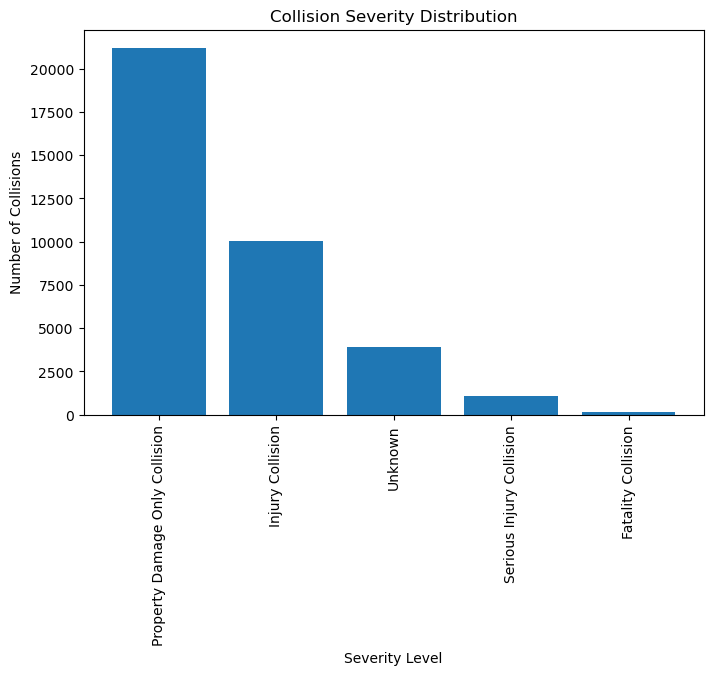

In [9]:
severity_counts = collisions_gdf['SEVERITYDESC'].value_counts()

plt.figure(figsize=(8,5))
plt.bar(severity_counts.index, severity_counts.values)
plt.xticks(rotation=90)
plt.title('Collision Severity Distribution')
plt.xlabel('Severity Level')
plt.ylabel('Number of Collisions')
plt.show()

### **Yearly Trends in Collisions**

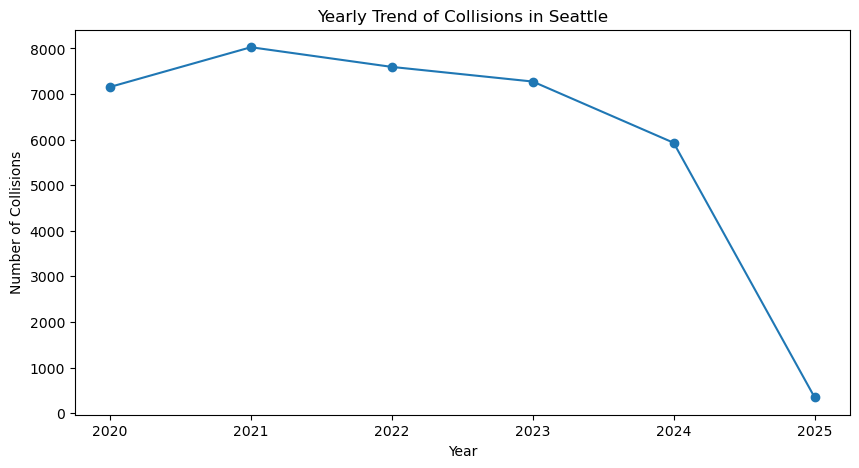

In [10]:
collision_by_year = collisions_gdf.groupby('YEAR').size()

plt.figure(figsize=(10,5))
plt.plot(collision_by_year.index, collision_by_year.values, marker='o')
plt.title('Yearly Trend of Collisions in Seattle')
plt.xlabel('Year')
plt.ylabel('Number of Collisions')
plt.show()

In [11]:
collision_by_year

YEAR
2020    7156
2021    8028
2022    7596
2023    7275
2024    5931
2025     348
dtype: int64

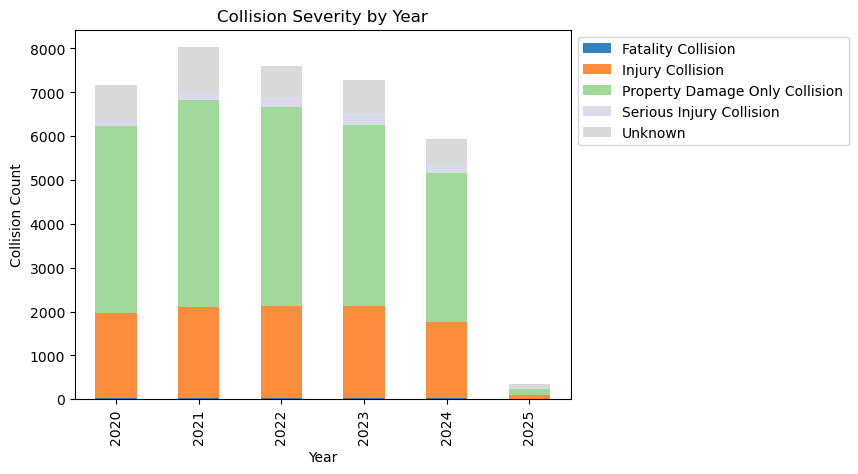

In [12]:
severity_by_year = collisions_gdf.groupby(["YEAR", "SEVERITYDESC"]).size().unstack()
severity_by_year.plot(kind="bar", stacked=True, colormap="tab20c")
plt.title("Collision Severity by Year")
plt.xlabel("Year")
plt.ylabel("Collision Count")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### **Collisions by Road User Type**

In [13]:
# Standardize shared micromobility labels
collisions_gdf["SHAREDMICROMOBILITYDESC"] = collisions_gdf["SHAREDMICROMOBILITYDESC"].replace({
    "Unknown": "Not Reported",  
    "No, Shared Micro Mobility was not involved": "Not Involved",
    "Yes, Shared Micro Mobility was involved": "Involved"
})

In [14]:
collision_counts = {
    "Pedestrians": (collisions_gdf['PEDCOUNT'] >0).sum(),
    "Cyclists": (collisions_gdf['PEDCYLCOUNT']>0).sum(),
    "Vehicles": (collisions_gdf['VEHCOUNT']>0).sum()
}
user_types = list(collision_counts.keys())
collision_values = list(collision_counts.values())

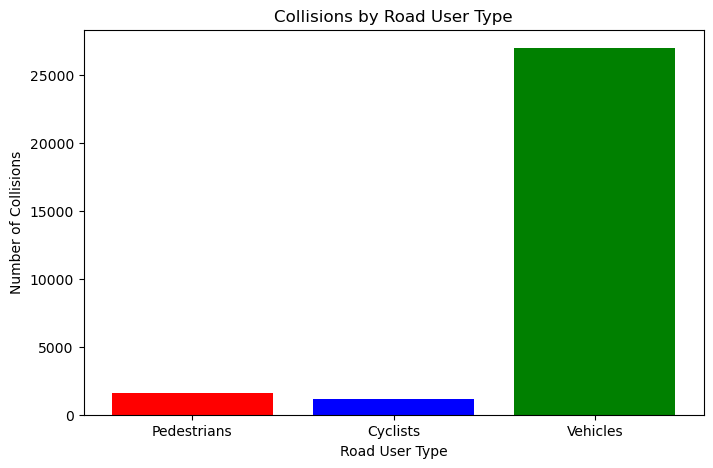

In [15]:
plt.figure(figsize=(8,5))
plt.bar(user_types,collision_values, color=['red','blue','green'])
plt.title('Collisions by Road User Type')
plt.xlabel('Road User Type')
plt.ylabel('Number of Collisions')
plt.show()

In [16]:
collision_counts

{'Pedestrians': np.int64(1608),
 'Cyclists': np.int64(1168),
 'Vehicles': np.int64(26984)}

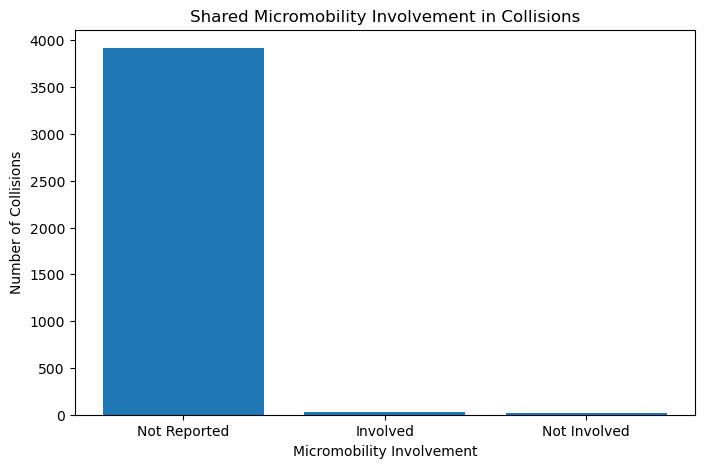

In [17]:
shared_micromobility_counts = collisions_gdf["SHAREDMICROMOBILITYDESC"].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(shared_micromobility_counts.index, shared_micromobility_counts.values)

plt.title("Shared Micromobility Involvement in Collisions")
plt.xlabel("Micromobility Involvement")
plt.ylabel("Number of Collisions")

plt.show()

In [18]:
shared_micromobility_counts

SHAREDMICROMOBILITYDESC
Not Reported    3918
Involved          31
Not Involved      17
Name: count, dtype: int64

## **Micromobility users Collisions**

In [19]:
#Filter collisions where PEDCOUNT or PEDCYLCOUNT > 0
micromobility_collisions = collisions_gdf[(collisions_gdf['PEDCOUNT'] > 0)|(collisions_gdf['PEDCYLCOUNT'] > 0)].copy()

print(f"Total Collisions Involving Micromobility Users: {len(micromobility_collisions)}")
micromobility_collisions.info()

Total Collisions Involving Micromobility Users: 2765
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2765 entries, 4 to 36257
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   STATUS                   2765 non-null   object        
 1   ADDRTYPE                 2765 non-null   object        
 2   INTKEY                   1800 non-null   float64       
 3   LOCATION                 2765 non-null   object        
 4   SEVERITYCODE             2765 non-null   object        
 5   SEVERITYDESC             2765 non-null   object        
 6   COLLISIONTYPE            2765 non-null   object        
 7   PERSONCOUNT              2765 non-null   int32         
 8   PEDCOUNT                 2765 non-null   int32         
 9   PEDCYLCOUNT              2765 non-null   int32         
 10  VEHCOUNT                 2765 non-null   int32         
 11  INJURIES                 2765 non-null

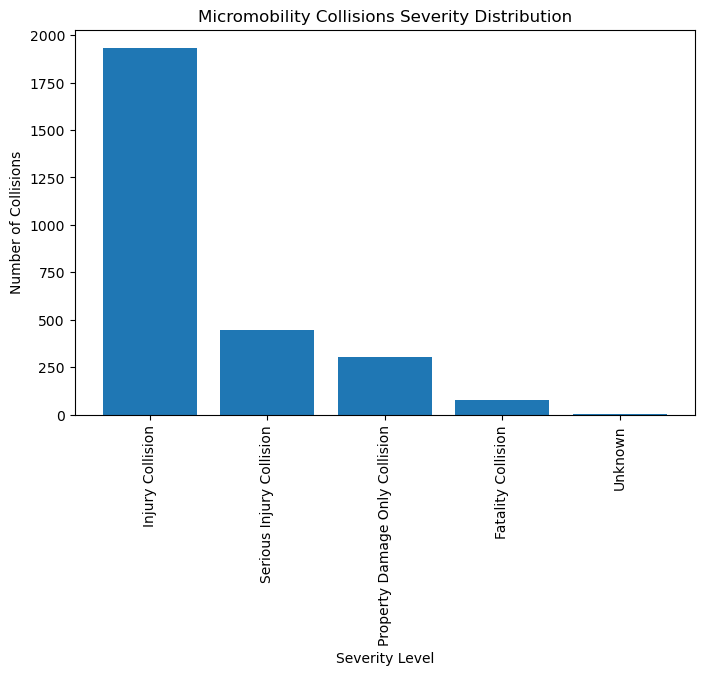

In [20]:
severity_counts = micromobility_collisions['SEVERITYDESC'].value_counts()

plt.figure(figsize=(8,5))
plt.bar(severity_counts.index, severity_counts.values)
plt.xticks(rotation=90)
plt.title('Micromobility Collisions Severity Distribution')
plt.xlabel('Severity Level')
plt.ylabel('Number of Collisions')
plt.show()

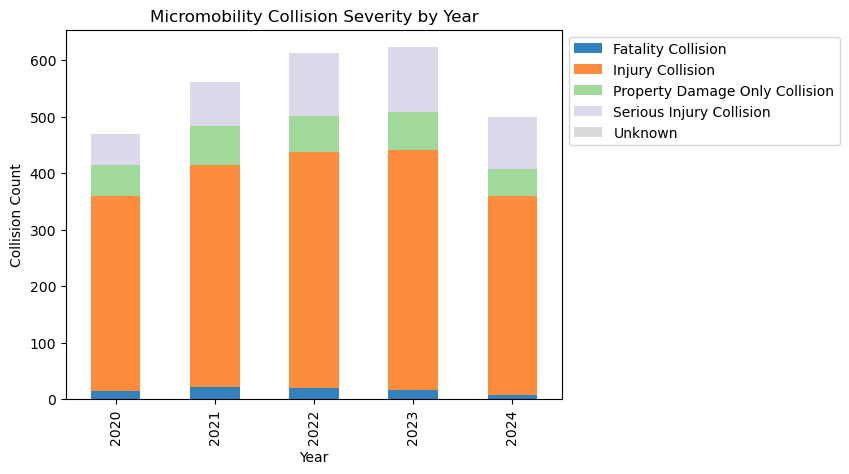

In [22]:
severity_by_year = micromobility_collisions.groupby(["YEAR", "SEVERITYDESC"]).size().unstack()
severity_by_year.plot(kind="bar", stacked=True, colormap="tab20c")
plt.title("Micromobility Collision Severity by Year")
plt.xlabel("Year")
plt.ylabel("Collision Count")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

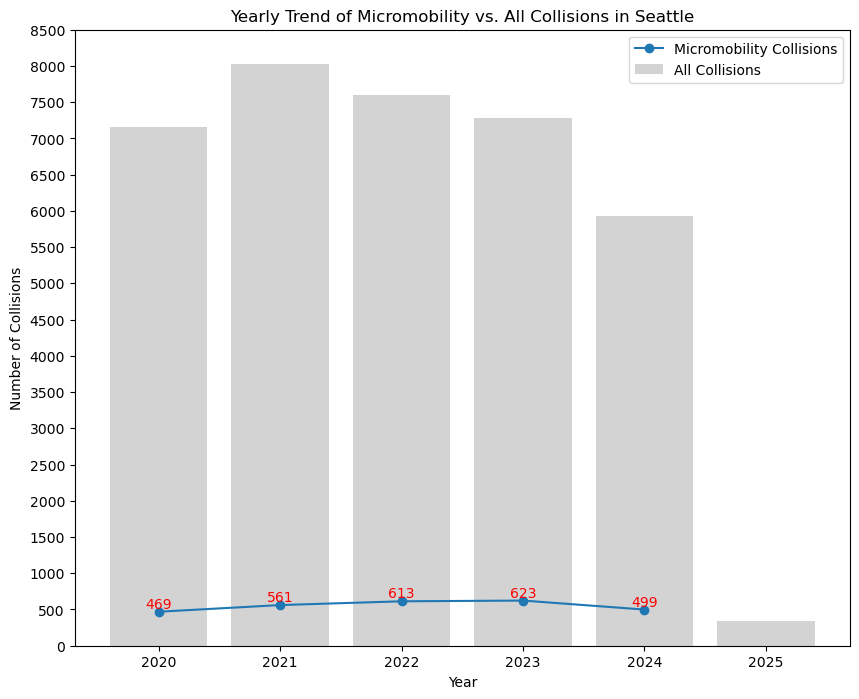

In [23]:
micro_collision_by_year = micromobility_collisions.groupby('YEAR').size()

plt.figure(figsize=(10,8))
plt.bar(collision_by_year.index, collision_by_year.values, color="lightgray", label="All Collisions")
plt.plot(micro_collision_by_year.index, micro_collision_by_year.values, marker='o', label="Micromobility Collisions")
for year, value in zip(micro_collision_by_year.index, micro_collision_by_year.values):
    plt.text(year, value + 50, str(value), ha="center", fontsize=10, color="red") 
y_max = max(collision_by_year.max(), micro_collision_by_year.max())  # Get max value
plt.yticks(np.arange(0, y_max + 500, 500))
plt.title('Yearly Trend of Micromobility vs. All Collisions in Seattle')
plt.xlabel('Year')
plt.ylabel('Number of Collisions')
plt.legend()
plt.show()

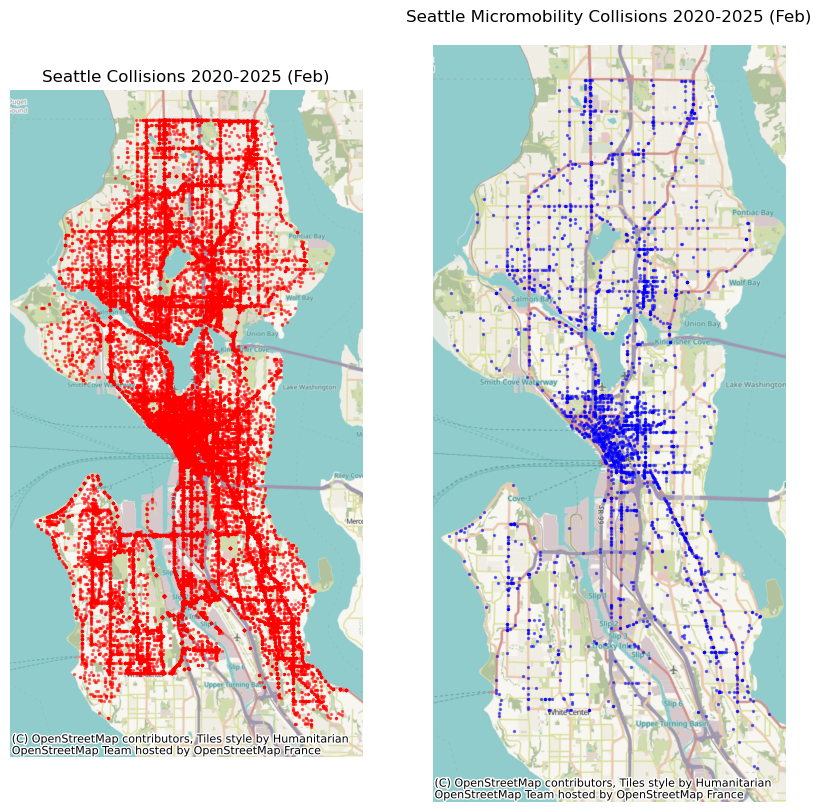

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

collisions_gdf.to_crs(epsg=3857).plot(
    ax=ax[0], 
    markersize=2, 
    alpha=0.5, 
    color="red"
)

ctx.add_basemap(ax[0], crs=collisions_gdf.to_crs(epsg=3857).crs)

ax[0].set_title("Seattle Collisions 2020-2025 (Feb)")
ax[0].set_axis_off()

micromobility_collisions.to_crs(epsg=3857).plot(
    ax=ax[1], 
    markersize=2, 
    alpha=0.5, 
    color="blue"
)

ctx.add_basemap(ax[1], crs=collisions_gdf.to_crs(epsg=3857).crs)

ax[1].set_title("Seattle Micromobility Collisions 2020-2025 (Feb)")
ax[1].set_axis_off()
plt.show()

/opt/conda/lib/python3.11/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


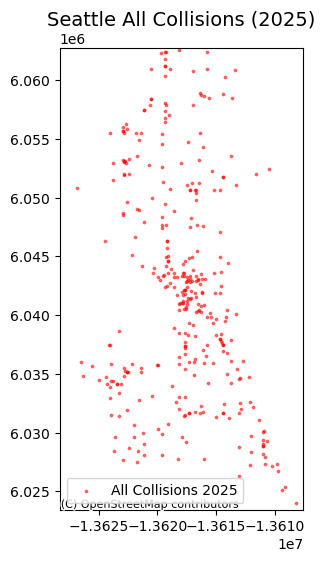

In [32]:
# ✅ Convert to Web Mercator (EPSG:3857) for proper basemap alignment
collisions_3857 = collisions_gdf.to_crs(epsg=3857)

# ✅ Get bounding box for Seattle's extent
xmin, ymin, xmax, ymax = collisions_3857.total_bounds

# ✅ Get sorted years for animation
years = sorted(collisions_3857["YEAR"].dropna().unique())

# ✅ Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# ✅ Plot basemap once (BEFORE animation starts)
ctx.add_basemap(ax, crs=collisions_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)  # Try different basemaps if needed
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# ✅ Ensure basemap is drawn before animation starts
plt.draw()

def update_all(year):
    """Update function for animating collision points without clearing the basemap"""
    
    # ✅ Remove previous year's collision points but keep basemap
    for coll in ax.collections:
        coll.remove()
    
    # ✅ Filter collisions for the given year
    yearly_collisions = collisions_3857[collisions_3857["YEAR"] == year]

    # ✅ Plot all collisions (red) AFTER basemap
    if not yearly_collisions.empty:
        yearly_collisions.plot(ax=ax, markersize=3, alpha=0.5, color="red", label=f"All Collisions {year}")

    ax.set_title(f"Seattle All Collisions ({year})", fontsize=14)
    ax.legend()

# ✅ Create animation for all collisions
ani_all = animation.FuncAnimation(fig, update_all, frames=years, repeat=True, interval=1000)

# ✅ Save animation
ani_all.save("seattle_all_collisions_fixed_basemap.gif", writer="pillow", dpi=100)

# ✅ Show animation
plt.show()

## **Proximity Analysis**

### **Collisions Near each existing infrasturcture**

In [39]:
base_crs = "EPSG:32610"
collisions_gdf = collisions_gdf.to_crs(base_crs)
micromobility_collisions = micromobility_collisions.to_crs(base_crs)

In [46]:
# Collisions within 50 m for existing bike facilities 
collisions_near_bikes = gpd.sjoin_nearest(
    micromobility_collisions,
    bike_facilities_gdf,
    how='left',
    max_distance=50,  
    distance_col='dist_to_bike' 
)
collisions_within_50m = collisions_near_bikes.dropna(subset=['dist_to_bike'])
print(f"Micromobility Collisions truly within 50 meters of existing bike facilities:")
print(f"{collisions_within_50m.shape[0]} about {collisions_within_50m.shape[0]/len(micromobility_collisions)*100:.2f} %")

Micromobility Collisions truly within 50 meters of existing bike facilities:
1648 about 59.60 %


In [47]:
# Collisions within 50 m for multi-use trails
collisions_near_multitrails = gpd.sjoin_nearest(
    micromobility_collisions,
    multi_use_trails_gdf,
    how='left',
    max_distance=50, 
    distance_col='dist_to_trails' 
)
collisions_within_50m = collisions_near_multitrails.dropna(subset=['dist_to_trails'])
print(f"Micromobility Collisions truly within 50 meters of multi-use trails:")
print(f"{collisions_within_50m.shape[0]} about {collisions_within_50m.shape[0]/len(micromobility_collisions)*100:.2f} %")

Micromobility Collisions truly within 50 meters of multi-use trails:
132 about 4.77 %


In [56]:
# Collisions within 50 m for sidewalks 
collisions_near_sidewalks = gpd.sjoin_nearest(
    micromobility_collisions,
    sidewalks_gdf,
    how='left',
    max_distance=50, 
    distance_col='dist_to_sidewalks' 
)
collisions_within_50m = collisions_near_sidewalks.dropna(subset=['dist_to_sidewalks'])
collisions_within_50m = collisions_within_50m.drop_duplicates(subset=['INCDATE', 'LOCATION'])

print(f"Micromobility Collisions truly within 50 meters of sidewalks:")
print(f"{collisions_within_50m.shape[0]} about {collisions_within_50m.shape[0]/len(micromobility_collisions)*100:.2f} %")

Micromobility Collisions truly within 50 meters of sidewalks:
2758 about 99.75 %


## **Hotspot of Collisions**

### **Use Kernel Density Estimation (KDE)**

Map Collisions hotspots that will identify high-risk areas.

/tmp/ipykernel_233/3722818464.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


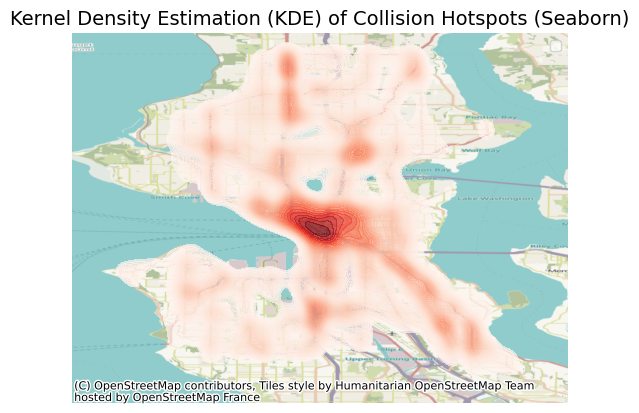

In [59]:
coords = np.array([(geom.x, geom.y) for geom in collisions_gdf.geometry if geom is not None])
x, y = coords[:, 0], coords[:, 1]
fig, ax = plt.subplots()

# Seaborn KDE Plot (density estimation)
sns.kdeplot(
    x=x, y=y, fill=True, cmap="Reds", bw_adjust=0.5, levels=50, ax=ax, alpha=0.7
)


# Add basemap
ctx.add_basemap(ax, crs=collisions_gdf.crs)

# Formatting
ax.set_title("Kernel Density Estimation (KDE) of Collision Hotspots (Seaborn)", fontsize=14)
ax.legend()
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

# Show plot
plt.show()

In [63]:
neighborhoods_file = "/home/jovyan/seattle-micromobility/data/processed/seattle_neighborhoods.geojson"
neighborhoods_url = "https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/master/data/neighborhoods.geojson"
response = requests.get(neighborhoods_url)
if response.status_code == 200:
    with open(neighborhoods_file, "wb") as f:
        f.write(response.content)
    print(f"Downloaded Seattle neighborhood boundaries to {neighborhoods_file}")
else:
    print("Failed to download neighborhood boundaries")

Downloaded Seattle neighborhood boundaries to /home/jovyan/seattle-micromobility/data/processed/seattle_neighborhoods.geojson


In [64]:
neighborhoods_gdf = gpd.read_file(neighborhoods_file)

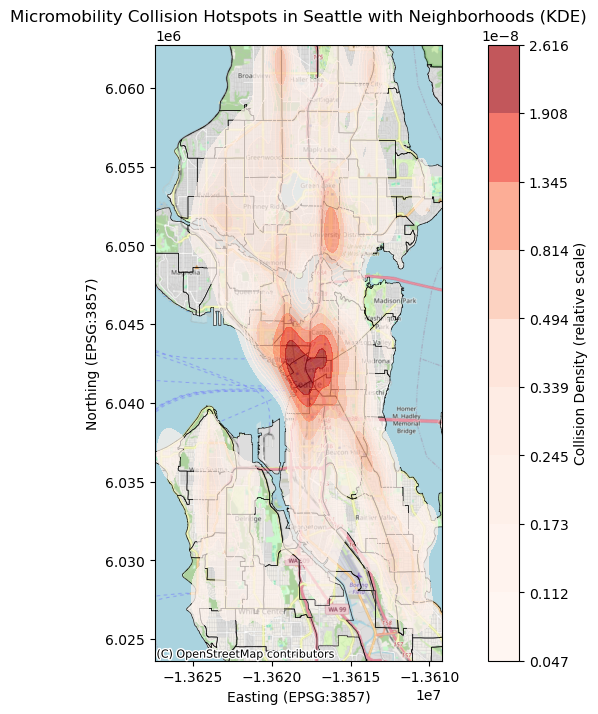

In [76]:
fig, ax = plt.subplots(figsize=(12, 8))
# Plot neighborhood boundaries
neighborhoods_3857.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.8)

# Add KDE with contours for colorbar
kde = sns.kdeplot(
    x=x, y=y, cmap="Reds", fill=True, bw_adjust=0.5, alpha=0.7, ax=ax,
    levels=10  # Add contour levels for colorbar
)
# Add colorbar using the contour levels
plt.colorbar(ax.collections[-1], ax=ax, label='Collision Density (relative scale)')

# Set extent to match collision data
ax.set_xlim(extent[0], extent[2])  # minx to maxx
ax.set_ylim(extent[1], extent[3])  # miny to maxy

plt.title("Micromobility Collision Hotspots in Seattle with Neighborhoods (KDE)")
plt.xlabel("Easting (EPSG:3857)")
plt.ylabel("Northing (EPSG:3857)")
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

### **Hotspots with Infrastructure Overlay**

We overlay bike facilities and multi-use trails to see if hotspots aligh with infrastructure.

In [87]:
bike_facilities_3857 = bike_facilities_gdf.to_crs("EPSG:3857")
multi_use_trails_3857 = multi_use_trails_gdf.to_crs("EPSG:3857")

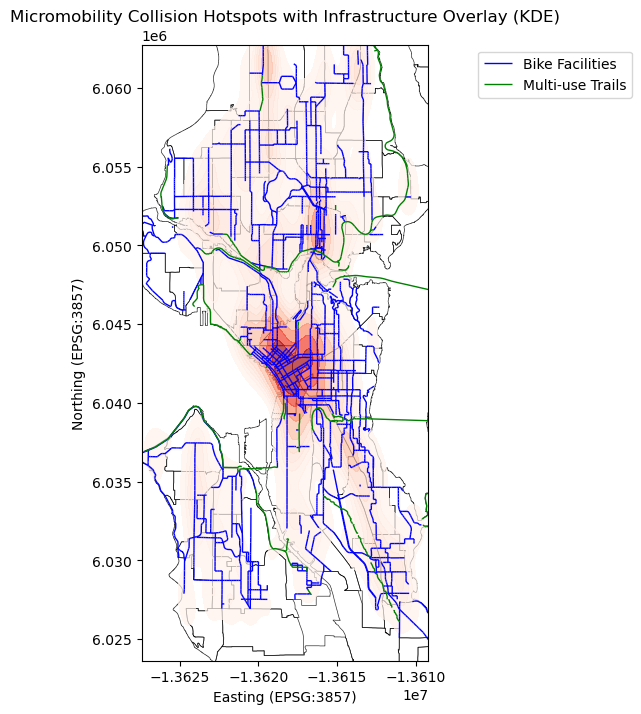

In [96]:
extent = micromobility_collisions.to_crs("EPSG:3857").total_bounds  # [minx, miny, maxx, maxy]

# KDE plot with neighborhood boundaries, infrastructure overlay, and colorbar
fig, ax = plt.subplots(figsize=(12, 8))
# Plot neighborhood boundaries
neighborhoods_3857.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.8)
# Add KDE layer with fill (replacing shade)
sns.kdeplot(
    x=x, y=y, cmap="Reds", fill=True, bw_adjust=0.5, alpha=0.7, ax=ax
)
# Overlay bike facilities and multi-use trails
bike_facilities_3857.plot(ax=ax, color='blue', linewidth=1, alpha=1, label='Bike Facilities')
multi_use_trails_3857.plot(ax=ax, color='green', linewidth=1, alpha=1, label='Multi-use Trails')

# Add legend
ax.legend(loc='upper left', bbox_to_anchor=(1.15, 1.0), frameon=True)

# Set extent to match collision data
ax.set_xlim(extent[0], extent[2])  # minx to maxx
ax.set_ylim(extent[1], extent[3])  # miny to maxy

plt.title("Micromobility Collision Hotspots with Infrastructure Overlay (KDE)")
plt.xlabel("Easting (EPSG:3857)")
plt.ylabel("Northing (EPSG:3857)")
#ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()